In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader , random_split
from scipy.stats import pearsonr
from scipy.stats import entropy

/home2/yehia.ahmed/SafeML_2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Unet Model Definition

In [2]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Contracting Path
        self.encoder1 = self.compress_block(in_channels=1, out_channels=64, kernel_size=3)
        self.encoder2 = self.compress_block(64, 128, 3)
        # Expanding Path
        self.decoder1 = self.expand_block(128, 64, 3)
        self.out = nn.Conv2d(64, 1, kernel_size=1)
    
    def __call__(self, x):
        # 1st encode image to an embedding
        x = self.encoder1(x)
        x = self.encoder2(x)
        
        # 2nd decode emb back to image
        x = self.decoder1(x) 
        x = self.out(x)
        return x
    
    def compress_block(self, in_channels, out_channels, kernel_size):
        #embedding path
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        return block
    
    def expand_block(self, in_channels, out_channels, kernel_size):
        #expanding  path
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(out_channels, out_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        return block


In [3]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
            

    def forward(self, x1):#, x2):
        x1 = self.up(x1)
        
        # input is CHW
        # diffY = x2.size()[2] - x1.size()[2]
        # diffX = x2.size()[3] - x1.size()[3]

        # x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
        #                 diffY // 2, diffY - diffY // 2])
        
        # x = torch.cat([x2, x1], dim=1)
        x=x1
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.up1 = Up(256, 128, bilinear)
        self.up2 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x = self.up1(x3)#, x2)
        x = self.up2(x)#, x1)
        logits = self.outc(x)
        return logits

# Example: Creating a U-Net model for 1 input channel and 10 output classes
model = UNet(n_channels=1, n_classes=10)
print(model)


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

## Creating and loading dataset

In [4]:
from SimpleDeepLearning.simple_deep_learning.mnist_extended.semantic_segmentation import (create_semantic_segmentation_dataset, display_segmented_image,
                                                                       display_grayscale_array, plot_class_masks)

2024-03-20 07:35:56.247443: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 07:35:57.776907: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
#Dataset Paramerters
num_train_samples=2000
num_test_samples=500
image_shape=(60, 60)
num_classes=10
batch_size = 32  
toShuffle=True

In [6]:
train_x, train_y, test_x, test_y = create_semantic_segmentation_dataset(num_train_samples=num_train_samples,
                                                                        num_test_samples=num_test_samples,
                                                                        image_shape=image_shape,
                                                                        num_classes=num_classes)
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(2000, 60, 60, 1) (2000, 60, 60, 10)
(500, 60, 60, 1) (500, 60, 60, 10)


In [7]:
# the permutation is needed to put the #channels in the end
train_x_tensor = torch.tensor(train_x, dtype=torch.float32).permute(0, 3, 1, 2)
train_y_tensor = torch.tensor(train_y, dtype=torch.float32).permute(0, 3, 1, 2)
test_x_tensor = torch.tensor(test_x, dtype=torch.float32).permute(0, 3, 1, 2) 
test_y_tensor = torch.tensor(test_y, dtype=torch.float32).permute(0, 3, 1, 2) 

# Cal train and Val sizes
dataset_size = len(train_x_tensor)
val_size = int(dataset_size * 0.2)  # 20% for validation
train_size = dataset_size - val_size

# Split train train and Val as 80-20 splits
train_dataset, val_dataset = random_split(TensorDataset(train_x_tensor, train_y_tensor), [train_size, val_size])


train_loader = DataLoader(TensorDataset(train_x_tensor,train_y_tensor), batch_size=batch_size, shuffle=toShuffle)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # Typically, no need to shuffle validation data
test_loader  = DataLoader(TensorDataset(test_x_tensor ,test_y_tensor ), batch_size=batch_size, shuffle=toShuffle)

In [8]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))
sample = next(iter(train_loader))
sample_x,sample_y = sample

63
13
16


torch.Size([1, 60, 60])
torch.Size([10, 60, 60])


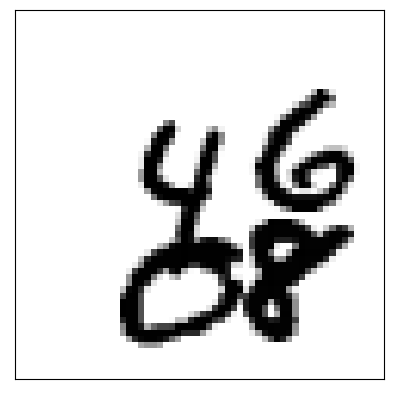

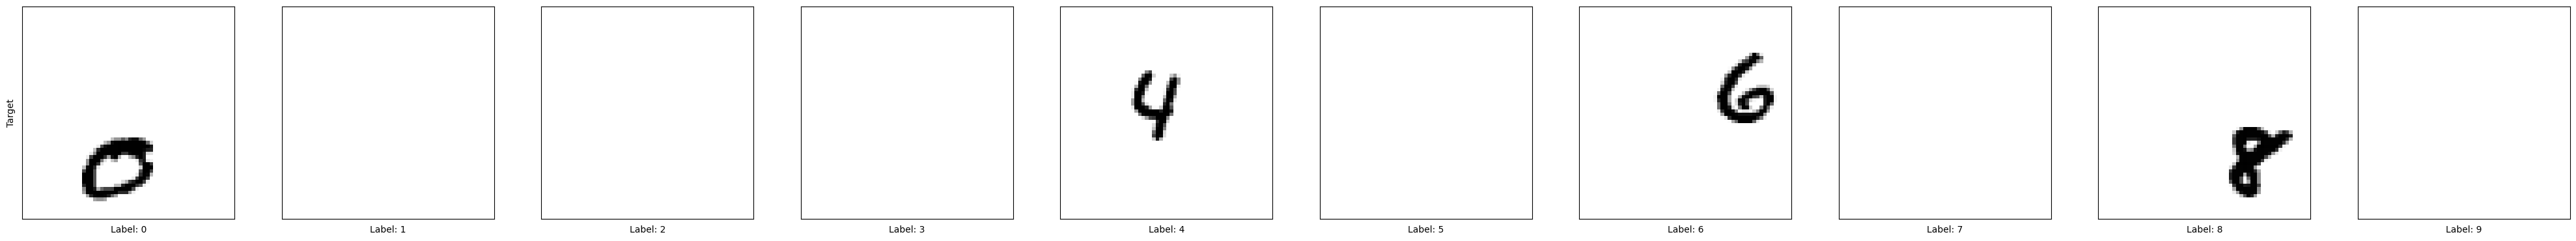

In [9]:
i = np.random.randint(len(sample_x))
print(sample_x[i].shape)
print(sample_y[i].shape)
display_grayscale_array(array=sample_x[i].permute(1,2,0))
plot_class_masks(sample_y[i].permute(1,2,0))

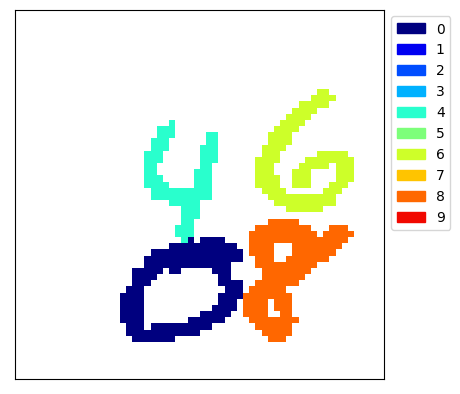

In [10]:
display_segmented_image(y=sample_y[i].permute(1,2,0))


## Trainning

In [11]:
ToTrain=False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model =  UNet(n_channels=1, n_classes=num_classes).to(device) #n_channels=1 for grayscale

# trainning Hyper-paramters
criterion = nn.BCEWithLogitsLoss() # loss func : has Sigmoid + BCELoss. more numerically stable than using a plain Sigmoid followed by a BCELoss as
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

Epoch 1, Train Loss: 0.4068, Val Loss: 0.1857
Epoch 2, Train Loss: 0.1051, Val Loss: 0.0694
Epoch 3, Train Loss: 0.0551, Val Loss: 0.0461
Epoch 4, Train Loss: 0.0394, Val Loss: 0.0364
Epoch 5, Train Loss: 0.0302, Val Loss: 0.0274
Epoch 6, Train Loss: 0.0243, Val Loss: 0.0240
Epoch 7, Train Loss: 0.0206, Val Loss: 0.0197
Epoch 8, Train Loss: 0.0177, Val Loss: 0.0161
Epoch 9, Train Loss: 0.0153, Val Loss: 0.0169
Epoch 10, Train Loss: 0.0136, Val Loss: 0.0130
Epoch 11, Train Loss: 0.0119, Val Loss: 0.0106
Epoch 12, Train Loss: 0.0106, Val Loss: 0.0108
Epoch 13, Train Loss: 0.0100, Val Loss: 0.0099
Epoch 14, Train Loss: 0.0090, Val Loss: 0.0082
Epoch 15, Train Loss: 0.0084, Val Loss: 0.0081
Epoch 16, Train Loss: 0.0077, Val Loss: 0.0073
Epoch 17, Train Loss: 0.0074, Val Loss: 0.0073
Epoch 18, Train Loss: 0.0071, Val Loss: 0.0069
Epoch 19, Train Loss: 0.0070, Val Loss: 0.0066
Epoch 20, Train Loss: 0.0066, Val Loss: 0.0062
Epoch 21, Train Loss: 0.0064, Val Loss: 0.0061
Epoch 22, Train Loss: 

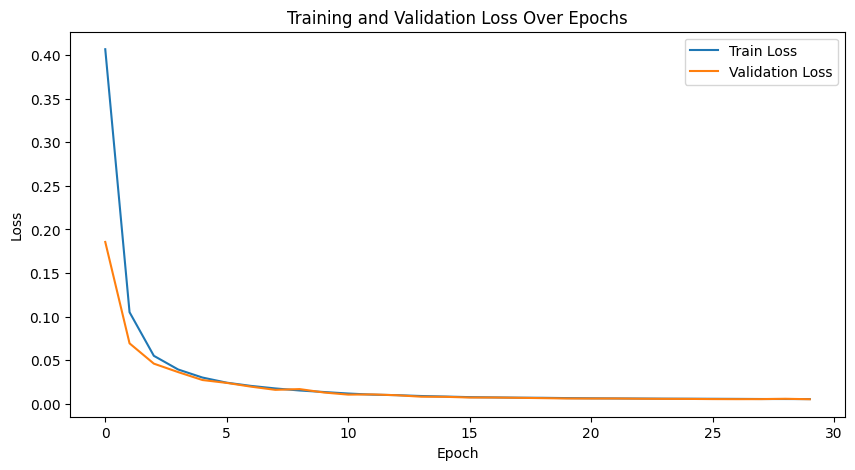

In [ ]:
if ToTrain:
    train_loss_values = []
    val_loss_values = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss_values.append(running_loss / len(train_loader))
        
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        val_loss_values.append(val_running_loss / len(val_loader))
        
        print(f"Epoch {epoch+1}, Train Loss: {train_loss_values[-1]:.4f}, Val Loss: {val_loss_values[-1]:.4f}")

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_values, label='Train Loss')
    plt.plot(val_loss_values, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

else:
    print("skipped training")


In [12]:
if ToTrain:
    torch.save(model.state_dict(), 'v1.pth')
    print("saved model as v1.pth")
else:
    model.load_state_dict(torch.load('v1.pth'))
    model.eval()
    print("loaded model from v1")

loaded model from v1


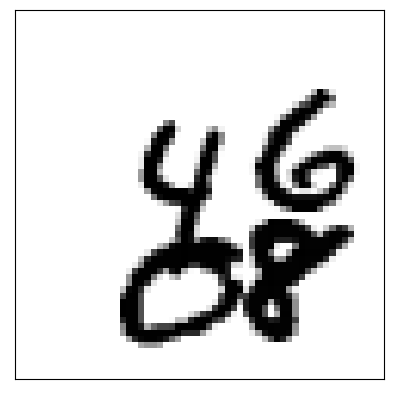

In [13]:
display_grayscale_array(array=sample_x[i].permute(1,2,0))

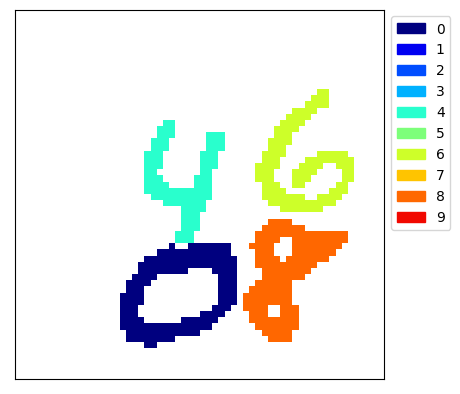

In [14]:
r = model(sample_x.to(device)[i:i+1])
display_segmented_image(y=r.permute(0,2,3,1).cpu()[0])

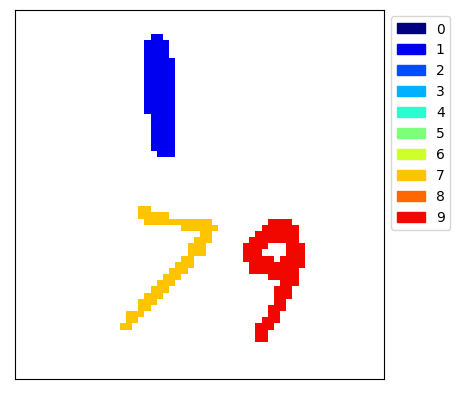

In [28]:
display_segmented_image(y=sample_y[i].permute(1,2,0).cpu())

As You can see the predicition is matching the ground truth for a sample from the train set.
Now lets Evaluate the model

## Model Evaluatation

### Evaluatation metrics

In [13]:
def batch_iou(preds, labels, num_classes):
    """
    Calculate mean Intersection over Union (mIoU) for a batch of predictions and labels.
    
    Parameters:
    preds (Tensor): Predictions tensor with shape (batch_size, height, width), containing class indices for each pixel.
    labels (Tensor): Labels tensor with shape (batch_size, height, width), containing class indices for each pixel.
    num_classes (int): The number of classes.
    
    Returns:
    float: The mean IoU for the batch.
    """
    # Initialize variables to store total intersection and union across the batch, for each class
    total_intersection = torch.zeros(num_classes)
    total_union = torch.zeros(num_classes)
    
    for cls in range(num_classes):
        # Find pixels of the current class
        pred_cls = preds == cls
        label_cls = labels == cls
        
        # Calculate intersection and union for the current class
        intersection = torch.logical_and(pred_cls, label_cls).sum()
        union = torch.logical_or(pred_cls, label_cls).sum()
        
        total_intersection[cls] += intersection
        total_union[cls] += union
    
    # Avoid division by zero for classes not present in predictions/labels
    ious = total_intersection / (total_union + 1e-6)
    
    # Calculate mean IoU across classes
    mean_iou = ious.mean().item()
    
    return mean_iou


In [14]:
def iou_score(outputs, labels, num_classes):
    """
    Calculate mean IoU for a batch of predictions and labels.
    
    Parameters:
    outputs (Tensor): A tensor of shape (batch_size, num_classes, height, width)
                      containing the predicted probabilities for each class.
    labels (Tensor): A tensor of shape (batch_size, num_classes, height, width)
                     containing the one-hot encoded ground truth labels.
    num_classes (int): The number of classes in the segmentation task.
    
    Returns:
    float: The mean IoU for the batch.
    """
    # Ensure the outputs are in binary format (e.g., 0 or 1)
    _, preds = torch.max(outputs, 1)  # Get the predicted class for each pixel
    preds = F.one_hot(preds, num_classes).permute(0, 3, 1, 2).float()  # Convert to one-hot encoding
    
    ious = []
    for cls in range(num_classes):  # Calculate IoU for each class
        intersection = (preds[:, cls] * labels[:, cls]).sum(dim=(1, 2))
        union = (preds[:, cls] + labels[:, cls]).clamp(0, 1).sum(dim=(1, 2))
        iou = intersection / (union + 1e-6)  # Avoid division by zero
        ious.append(iou.mean().item())  # Average IoU for this class across the batch
    
    mean_iou = sum(ious) / len(ious)

    return mean_iou  # Return mean IoU across all classes

In [31]:
def calculate_mean_iou(predictions, ground_truth, num_classes=10):
    """
    Calculate the Mean Intersection over Union (Mean IoU) given one-hot encoded predictions
    and ground truth labels.
    """
    # Flatten the height and width dimensions
    predictions = predictions.reshape(-1, num_classes).bool()
    ground_truth = ground_truth.reshape(-1, num_classes).bool()
    
    iou_per_class = []
    for cls in range(num_classes):
        true_positive = (predictions[:, cls] & ground_truth[:, cls]).sum().float()
        false_positive = (predictions[:, cls] & ~ground_truth[:, cls]).sum().float()
        false_negative = (~predictions[:, cls] & ground_truth[:, cls]).sum().float()
        union = true_positive + false_positive + false_negative
        iou = true_positive / (union + 1e-6)
        iou_per_class.append(iou)
    
    mean_iou = torch.stack(iou_per_class).mean().item()
    return mean_iou

def calculate_mean_entropy(logits):
    """
    Calculate the Mean Entropy of the model's predictions (logits).
    """
    probabilities = F.softmax(logits, dim=1)
    log_probabilities = F.log_softmax(logits, dim=1)
    entropy = -(probabilities * log_probabilities).sum(dim=1).mean().item()
    return entropy

logits = model(sample_x.to(device))
# Convert logits to one-hot encoded predictions
probabilities = F.softmax(logits, dim=1)
predictions = torch.argmax(probabilities, dim=1)
predictions_one_hot = F.one_hot(predictions, num_classes=logits.shape[1]).permute(0, 3, 1, 2)

mean_iou = calculate_mean_iou(predictions_one_hot, sample_y.to(device), num_classes=10)
mean_entropy = calculate_mean_entropy(logits)

print(f"Mean IoU: {mean_iou}")
print(f"Mean Entropy: {mean_entropy}")


Mean IoU: 0.11118628084659576
Mean Entropy: 1.9686205387115479


In [63]:
r[0,:,0,0]

tensor([ 0.0043, -0.0099, -0.0873,  0.0101, -0.0691,  0.0943, -0.0145, -0.0380,
        -0.0500, -0.0836], device='cuda:0', grad_fn=<SelectBackward0>)

In [33]:
model.eval()
logits=model(sample_x.to(device)).to(device)
softmax_outputs = torch.softmax(logits, dim=1).to(device) #normalize the logits to make pred
# print(batch_iou(softmax_outputs, sample_y.to(device),num_classes))
print(iou_score(logits, sample_y.to(device),num_classes))

NameError: name 'iou_score' is not defined

In [32]:
model.eval()
test_mIoU, test_mEntropy = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)  # model outputs is just  logits, as the loss funtion had the sigmoid included in it
        softmax_outputs = torch.softmax(outputs, dim=1) #normalize the logits to make pred
        
        # Calculate entropy for each pixel and then average over the batch
        batch_Entropy = entropy(softmax_outputs.cpu().numpy(), axis=1).mean(axis=(1, 2))
        test_mEntropy.extend(batch_Entropy)
        
        # Assuming you have a function to calculate IoU per batch, named `batch_iou`
        mIoU = iou_score(softmax_outputs, labels,num_classes)
        test_mIoU.append(mIoU)

# Convert lists to numpy arrays for correlation calculation
test_mEntropy = np.array(test_mEntropy)
test_miou = np.array(test_mIoU)

# Calculate and print correlation
correlation = np.corrcoef(test_mEntropy, test_miou)[0, 1]
print(f"Correlation between mean entropy (uncertainty) and mIoU: {correlation:.4f}")


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 500 and the array at index 1 has size 16

In [ ]:
# Convert lists to numpy arrays
test_entropies = np.array(test_entropies)
test_ious = np.array(test_ious)

# Compute mean entropy and mean IoU for reporting
mean_entropy = np.mean(test_entropies)
mean_iou = np.mean(test_ious)

print(f"Mean Entropy (Uncertainty): {mean_entropy}")
print(f"Mean IoU: {mean_iou}")

In [ ]:
correlation = np.corrcoef(test_entropies, test_ious)[0, 1]
print(f"Correlation between Uncertainty (Mean Entropy) and mIoU: {correlation}")
